In [3]:
import os
import shutil


# download files from https://github.com/brendenlake/omniglot/tree/master/python and run this

families_background = \
    ['Japanese_(hiragana)',
     'Futurama',
     'Early_Aramaic',
     'Mkhedruli_(Georgian)',
     'Malay_(Jawi_-_Arabic)',
     'Sanskrit',
     'Asomtavruli_(Georgian)',
     'Armenian',
     'Arcadian',
     'Hebrew',
     'Alphabet_of_the_Magi',
     'Syriac_(Estrangelo)',
     'Blackfoot_(Canadian_Aboriginal_Syllabics)',
     'Balinese',
     'N_Ko',
     'Greek',
     'Burmese_(Myanmar)',
     'Braille',
     'Japanese_(katakana)',
     'Tifinagh',
     'Cyrillic',
     'Tagalog',
     'Gujarati',
     'Latin',
     'Anglo-Saxon_Futhorc',
     'Grantha',
     'Korean',
     'Ojibwe_(Canadian_Aboriginal_Syllabics)',
     'Bengali',
     'Inuktitut_(Canadian_Aboriginal_Syllabics)']

families_evaluation = \
    ['ULOG',
     'Old_Church_Slavonic_(Cyrillic)',
     'Oriya',
     'Mongolian',
     'Syriac_(Serto)',
     'Atlantean',
     'Angelic',
     'Kannada',
     'Tibetan',
     'Ge_ez',
     'Manipuri',
     'Avesta',
     'Atemayar_Qelisayer',
     'Sylheti',
     'Aurek-Besh',
     'Glagolitic',
     'Malayalam',
     'Gurmukhi',
     'Tengwar',
     'Keble']

# split font families
families_train = \
    [('images_background', fam) for (k, fam) in enumerate(families_background) if k % 4 != 0] +\
    [('images_evaluation', fam) for (k, fam) in enumerate(families_evaluation) if k % 4 != 0]
families_test = \
    [('images_background', fam) for (k, fam) in enumerate(families_background) if k % 4 == 0] +\
    [('images_evaluation', fam) for (k, fam) in enumerate(families_evaluation) if k % 4 == 0]

# copy to train dir
if not os.path.exists('train'): os.makedirs('train')
for dn, fam in families_train:
    shutil.copytree(os.path.join(dn, fam), os.path.join('train', fam))

if not os.path.exists('test'): os.makedirs('test')
for dn, fam in families_test:
    shutil.copytree(os.path.join(dn, fam), os.path.join('test', fam))

In [4]:
import numpy as np
from scipy.ndimage import rotate
from scipy.ndimage import shift as scipy_shift
import scipy.misc
from scipy.misc import imread, imresize

import os
import random


def time_offset_input(labels_and_images):
    labels, images = zip(*labels_and_images)
    time_offset_labels = (None,) + labels[:-1]
    return zip(images, time_offset_labels)

def load_transform(image_path, angle=0., shift=(0, 0), size=(20, 20)):
    # Load the image
    original = imread(image_path, flatten=True)
    original /= np.max(original)
    # Rotate the image
    rotated = np.maximum(np.minimum(rotate(original, angle=angle, cval=1.), 1.), 0.)
    # Shift the image
    shifted = scipy_shift(rotated, shift=shift, cval=1.)
    # Resize the image
    resized = np.asarray(scipy.misc.imresize(rotated, size=size), dtype=np.float32) / 255.
    # Invert the image
    inverted = 1. - resized
    max_value = np.max(inverted)
    if max_value > 0.:
        inverted /= max_value
    return inverted

def rotate_right(img, angle):    
    if angle == 0:
        return img  
    elif angle == 1:  # 90 degree
        return img.T[:,::-1]
    elif angle == 2:  # 180 degree
        return img[::-1,::-1]
    elif angle == 3:  # 270 degree
        return img.T[::-1,:]
    else:
        raise ValueError('angle must be 0, 1, 2 or 3')

In [5]:
"""
Run this script after s01.
"""
import sys
sys.path.append('../../')  
import os
#from utils.images import load_transform
from collections import defaultdict

import numpy as np



def load_augment(data_folder, ratio, max_shift, max_rotation, size):
    """
    Args
        data_folder
        ratio (int): data is augmented in this ratio        
        max_shift (int): max shift in original image 
        max_rotation (float): max rotatin in degree
    """
    char_folders = [os.path.join(data_folder, family, character) 
               for family in os.listdir(data_folder) 
               for character in os.listdir(os.path.join(data_folder, family))]

    tmp_dict = defaultdict(list)
    for fld in char_folders:
        print(fld)
        for img in os.listdir(fld):
            # original data
            t_image = load_transform(os.path.join(fld, img), size=size)
            tmp_dict[fld].append(t_image)
            # augmented data
            if ratio != 1:
                angles = np.random.uniform(-max_rotation, max_rotation, size=ratio-1)
                shifts = np.random.randint(-max_shift, max_shift + 1, size=(ratio-1, 2))     
                for angle, shift in zip(angles, shifts):
                    t_image = load_transform(os.path.join(fld, img), 
                                             angle=angle, shift=shift, size=size)
                    tmp_dict[fld].append(t_image)
    results = {key : np.array(value) for key, value in tmp_dict.items()}
    return results


if __name__ == '__main__':    
    print('Convert train dataset')
    data_folder = 'train'
    train_data = load_augment(data_folder, ratio=10, max_shift=5, max_rotation=15.0, size=(28,28))
    np.savez('train.npz', **train_data)

    print('Convert test dataset')    
    data_folder = 'test'
    test_data = load_augment(data_folder, ratio=1, max_shift=0, max_rotation=0, size=(28,28))
    np.savez('test.npz', **test_data)

Convert train dataset
train/Armenian/character19


/home/ramona/anaconda3/envs/mlp/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/ramona/anaconda3/envs/mlp/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


train/Armenian/character02
train/Armenian/character22
train/Armenian/character37
train/Armenian/character01
train/Armenian/character12
train/Armenian/character41
train/Armenian/character29
train/Armenian/character35
train/Armenian/character33
train/Armenian/character17
train/Armenian/character09
train/Armenian/character40
train/Armenian/character39
train/Armenian/character18
train/Armenian/character03
train/Armenian/character16
train/Armenian/character23
train/Armenian/character36
train/Armenian/character04
train/Armenian/character10
train/Armenian/character08
train/Armenian/character07
train/Armenian/character24
train/Armenian/character21
train/Armenian/character11
train/Armenian/character26
train/Armenian/character20
train/Armenian/character28
train/Armenian/character31
train/Armenian/character06
train/Armenian/character30
train/Armenian/character13
train/Armenian/character34
train/Armenian/character14
train/Armenian/character25
train/Armenian/character32
train/Armenian/character27
t

train/Old_Church_Slavonic_(Cyrillic)/character45
train/Old_Church_Slavonic_(Cyrillic)/character26
train/Old_Church_Slavonic_(Cyrillic)/character20
train/Old_Church_Slavonic_(Cyrillic)/character28
train/Old_Church_Slavonic_(Cyrillic)/character31
train/Old_Church_Slavonic_(Cyrillic)/character06
train/Old_Church_Slavonic_(Cyrillic)/character30
train/Old_Church_Slavonic_(Cyrillic)/character44
train/Old_Church_Slavonic_(Cyrillic)/character13
train/Old_Church_Slavonic_(Cyrillic)/character34
train/Old_Church_Slavonic_(Cyrillic)/character14
train/Old_Church_Slavonic_(Cyrillic)/character25
train/Old_Church_Slavonic_(Cyrillic)/character32
train/Old_Church_Slavonic_(Cyrillic)/character27
train/Old_Church_Slavonic_(Cyrillic)/character15
train/Old_Church_Slavonic_(Cyrillic)/character43
train/Old_Church_Slavonic_(Cyrillic)/character05
train/Old_Church_Slavonic_(Cyrillic)/character38
train/Tifinagh/character19
train/Tifinagh/character02
train/Tifinagh/character22
train/Tifinagh/character37
train/Tifi

train/Avesta/character22
train/Avesta/character01
train/Avesta/character12
train/Avesta/character17
train/Avesta/character09
train/Avesta/character18
train/Avesta/character03
train/Avesta/character16
train/Avesta/character23
train/Avesta/character04
train/Avesta/character10
train/Avesta/character08
train/Avesta/character07
train/Avesta/character24
train/Avesta/character21
train/Avesta/character11
train/Avesta/character26
train/Avesta/character20
train/Avesta/character06
train/Avesta/character13
train/Avesta/character14
train/Avesta/character25
train/Avesta/character15
train/Avesta/character05
train/N_Ko/character19
train/N_Ko/character02
train/N_Ko/character22
train/N_Ko/character01
train/N_Ko/character12
train/N_Ko/character29
train/N_Ko/character33
train/N_Ko/character17
train/N_Ko/character09
train/N_Ko/character18
train/N_Ko/character03
train/N_Ko/character16
train/N_Ko/character23
train/N_Ko/character04
train/N_Ko/character10
train/N_Ko/character08
train/N_Ko/character07
train/N_K

train/Gurmukhi/character02
train/Gurmukhi/character22
train/Gurmukhi/character37
train/Gurmukhi/character01
train/Gurmukhi/character12
train/Gurmukhi/character41
train/Gurmukhi/character29
train/Gurmukhi/character35
train/Gurmukhi/character33
train/Gurmukhi/character17
train/Gurmukhi/character09
train/Gurmukhi/character40
train/Gurmukhi/character39
train/Gurmukhi/character18
train/Gurmukhi/character03
train/Gurmukhi/character16
train/Gurmukhi/character23
train/Gurmukhi/character36
train/Gurmukhi/character04
train/Gurmukhi/character10
train/Gurmukhi/character08
train/Gurmukhi/character07
train/Gurmukhi/character24
train/Gurmukhi/character21
train/Gurmukhi/character42
train/Gurmukhi/character11
train/Gurmukhi/character45
train/Gurmukhi/character26
train/Gurmukhi/character20
train/Gurmukhi/character28
train/Gurmukhi/character31
train/Gurmukhi/character06
train/Gurmukhi/character30
train/Gurmukhi/character44
train/Gurmukhi/character13
train/Gurmukhi/character34
train/Gurmukhi/character14
t

train/Alphabet_of_the_Magi/character10
train/Alphabet_of_the_Magi/character08
train/Alphabet_of_the_Magi/character07
train/Alphabet_of_the_Magi/character11
train/Alphabet_of_the_Magi/character20
train/Alphabet_of_the_Magi/character06
train/Alphabet_of_the_Magi/character13
train/Alphabet_of_the_Magi/character14
train/Alphabet_of_the_Magi/character15
train/Alphabet_of_the_Magi/character05
train/Latin/character19
train/Latin/character02
train/Latin/character22
train/Latin/character01
train/Latin/character12
train/Latin/character17
train/Latin/character09
train/Latin/character18
train/Latin/character03
train/Latin/character16
train/Latin/character23
train/Latin/character04
train/Latin/character10
train/Latin/character08
train/Latin/character07
train/Latin/character24
train/Latin/character21
train/Latin/character11
train/Latin/character26
train/Latin/character20
train/Latin/character06
train/Latin/character13
train/Latin/character14
train/Latin/character25
train/Latin/character15
train/Lati

test/Malay_(Jawi_-_Arabic)/character25
test/Malay_(Jawi_-_Arabic)/character32
test/Malay_(Jawi_-_Arabic)/character27
test/Malay_(Jawi_-_Arabic)/character15
test/Malay_(Jawi_-_Arabic)/character05
test/Malay_(Jawi_-_Arabic)/character38
test/Syriac_(Serto)/character19
test/Syriac_(Serto)/character02
test/Syriac_(Serto)/character22
test/Syriac_(Serto)/character01
test/Syriac_(Serto)/character12
test/Syriac_(Serto)/character17
test/Syriac_(Serto)/character09
test/Syriac_(Serto)/character18
test/Syriac_(Serto)/character03
test/Syriac_(Serto)/character16
test/Syriac_(Serto)/character23
test/Syriac_(Serto)/character04
test/Syriac_(Serto)/character10
test/Syriac_(Serto)/character08
test/Syriac_(Serto)/character07
test/Syriac_(Serto)/character21
test/Syriac_(Serto)/character11
test/Syriac_(Serto)/character20
test/Syriac_(Serto)/character06
test/Syriac_(Serto)/character13
test/Syriac_(Serto)/character14
test/Syriac_(Serto)/character15
test/Syriac_(Serto)/character05
test/Cyrillic/character19
test

In [ ]:
import numpy as np
import os
import random
from scipy.misc import imread

from images import load_transform, rotate_right

class OmniglotGenerator(object):
    """OmniglotGenerator
    Args:
        data_file (str): 'data/omniglot/train.npz' or 'data/omniglot/test.npz' 
        nb_classes (int): number of classes in an episode
        nb_samples_per_class (int): nuber of samples per class in an episode
        batchsize (int): number of episodes in each mini batch
        max_iter (int): max number of episode generation
        xp: numpy or cupy
    """
    def __init__(self, data_file, nb_classes=1, nb_samples_per_class=10, 
                 batchsize=64, max_iter=None, xp=np):
        super(OmniglotGenerator, self).__init__()
        self.data_file = data_file
        self.nb_classes = nb_classes
        self.nb_samples_per_class = nb_samples_per_class
        self.batchsize = batchsize
        self.max_iter = max_iter
        self.xp = xp
        self.num_iter = 0
        self.data = self._load_data(self.data_file, self.xp)

    def _load_data(self, data_file, xp):
        data_dict = np.load(data_file)
        return {key: xp.array(val) for (key, val) in data_dict.items()}

    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def next(self):
        if (self.max_iter is None) or (self.num_iter < self.max_iter):
            self.num_iter += 1
            _images, _labels = zip(*[self.sample(self.nb_classes, self.nb_samples_per_class) 
                           for i in range(self.batchsize)])
            images = [
                self.xp.concatenate(map(lambda x: x.reshape((1,-1)), _img), axis=0)
                for _img in zip(*_images)]
            labels = [_lbl for _lbl in zip(*_labels)]
            return (self.num_iter - 1), (images, labels)
        else:
            raise StopIteration()

    def sample(self, nb_classes, nb_samples_per_class):
        sampled_characters = random.sample(self.data.keys(), nb_classes) # list of keys
        labels_and_images = []
        for (k, char) in enumerate(sampled_characters):
            deg = random.sample(range(4), 1)[0]
            _imgs = self.data[char]
            _ind = random.sample(range(len(_imgs)), nb_samples_per_class)
            labels_and_images.extend([(k, rotate_right(_imgs[i], deg).flatten()) for i in _ind])
            
        random.shuffle(labels_and_images)
        sequence_length = len(labels_and_images)
        labels, images = zip(*labels_and_images)
        return images, labels


In [81]:
import numpy as np
import os
import pickle

from torch.utils import data

class OmniglotSetsDataset(data.Dataset):
    def __init__(self, data_dir = None, split="train", K =20):
        self.split = split
        if split == "train":
            a = np.load("train.npz")
        else:
            a = np.load("test.npz")
        t = {key: np.array(val) for (key, val) in a.items()}
        self.labels = []
        self.images = []
        ks = list(t.keys())
        random.shuffle(ks)
        for k, char in enumerate(ks):
            deg = random.sample(range(4), 1)[0]
            _imgs = t[char]
            _ind = random.sample(range(200), K)
            self.images.extend([np.array([rotate_right(_imgs[i], deg) if self.split == "train" else _imgs[i] 
                                          for i in _ind])])
            self.labels.extend(k for i in _ind)

    def __getitem__(self, item):
        if self.split == "train" or self.split == "test":
            return self.images[item]
        else:
            return self.images[item], self.label[item]

    def __len__(self):
        return len(self.images)

In [19]:
import gzip
import numpy as np
from copy import deepcopy
import random
import os
import pickle
import torch
#from skimage.morphology import dilation, square
#from skimage.transform import rotate
from torch.utils import data


def load_mnist(data_dir):

    def load_images(path):
        with gzip.open(path) as bytestream:
            # read meta information
            header_buffer = bytestream.read(16)
            header = np.frombuffer(header_buffer, dtype='>i4')
            magic, n, x, y = header
            # read data
            buffer = bytestream.read(x * y * n)
            data = np.frombuffer(buffer, dtype='>u1').astype(np.float32)
            data = data.reshape(n, x * y)
        return data

    def load_labels(path):
        with gzip.open(path) as bytestream:
            # read meta information
            header_buffer = bytestream.read(8)
            header = np.frombuffer(header_buffer, dtype='>i4')
            magic, n = header
            # read data
            buffer = bytestream.read(n)
            data = np.frombuffer(buffer, dtype=np.uint8).astype(np.int32)
        return data

    train_images_gz = 'train-images-idx3-ubyte.gz'
    train_labels_gz = 'train-labels-idx1-ubyte.gz'

    test_images_gz = 't10k-images-idx3-ubyte.gz'
    test_labels_gz = 't10k-labels-idx1-ubyte.gz'

    train_images = load_images(os.path.join(data_dir, train_images_gz))
    test_images = load_images(os.path.join(data_dir, test_images_gz))
    images = np.vstack((train_images, test_images)) / 255

    train_labels = load_labels(os.path.join(data_dir, train_labels_gz))
    test_labels = load_labels(os.path.join(data_dir, test_labels_gz))
    labels = np.hstack((train_labels, test_labels))

    n = len(labels)
    one_hot = np.zeros((n, 10))
    one_hot[range(n), labels] = 1
    labels = one_hot

    return images, labels


def load_mnist_test_batch(data_dir, batch_size):
    images, one_hot_labels = load_mnist(data_dir=data_dir)
    labels = np.argmax(one_hot_labels, axis=1)
    ixs = [np.random.choice(np.where(labels == i)[0], size=5, replace=False)
           for i in range(10)]
    batch = np.array([images[ix] for ix in ixs])
    return torch.from_numpy(batch).clone().repeat((batch_size // 10) + 1, 1, 1)[:batch_size]


import numpy as np
import os
import pickle

from torch.utils import data

def rotate_right(img, angle):    
    if angle == 0:
        return img  
    elif angle == 1:  # 90 degree
        return img.T[:,::-1]
    elif angle == 2:  # 180 degree
        return img[::-1,::-1]
    elif angle == 3:  # 270 degree
        return img.T[::-1,:]
    else:
        raise ValueError('angle must be 0, 1, 2 or 3')
        
class OmniglotSetsDataset(data.Dataset):
    def __init__(self, data_dir = None, split="train", sample_size = 20, augment="True"):
        self.split = split
        if split == "train":
            a = np.load("train.npz")
        else:
            a = np.load("test.npz")
        t = {key: np.array(val) for (key, val) in a.items()}
        self.labels = []
        self.images = []
        ks = list(t.keys())
        random.shuffle(ks)
        for k, char in enumerate(ks):
            _imgs = t[char]
            _ind = random.sample(range(len(_imgs)), sample_size)
            self.images.extend([np.array([rotate_right(_imgs[i], random.sample(range(4), 1)[0]) 
                                          if self.split == "train" else _imgs[i] for i in _ind])])
            self.labels.extend(k for i in _ind)

    def __getitem__(self, item):
        if self.split == "train" or self.split == "test":
            return self.images[item]
        else:
            return self.images[item], self.label[item]

    def __len__(self):
        return len(self.images)

In [20]:
train_dataset = OmniglotSetsDataset(split='test')

# create loaders
train_loader = data.DataLoader(dataset=train_dataset, batch_size=32,
                               shuffle=True, num_workers=0, drop_last=True)

In [21]:
c=next(iter(train_loader))

In [22]:
c.shape

torch.Size([32, 20, 28, 28])

In [6]:
import matplotlib.pyplot as plt

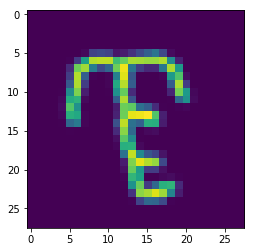

In [15]:
plt.imshow(c[2,7,:,:])